In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

### seeding for reproducibility purposes

In [2]:
seed = 120
torch.manual_seed(seed)

### helper functions

In [3]:
def Ising_diag_H(Jz, samples):
    """samples: (numsamples, N)
       Jz: N-1

       input spin: 0 or 1 ~ correspond to physics: -1 or 1
    """
    numsamples = samples.shape[0]
    N = samples.shape[1]
    energy = torch.zeros(numsamples)

    for i in range(N-1):
        values = samples[:,i] + samples[:, i+1]
        valuesN = torch.clone(values)
        valuesN[(values == 2) + (values == 0)] = 1
        valuesN[values == 1] = -1

        energy += valuesN*(-Jz[i])

    return energy

def Ising_local_E(Jz, Bx, samples, f_probs):
    """Randomly choose some states (not required to select all)
       samples: (numsamples, N)
       Jz: N-1
       Bx: magnetic field
       f_probs: functions to calculate the probabilities

       input spin: 0 or 1 ~ correspond to physics: -1 or 1
    """
    numsamples = samples.shape[0]
    N = samples.shape[1]

    local_energy = torch.zeros(numsamples)
    queue_samples = torch.zeros([N+1, numsamples, N])

    # diagonal elements (interaction)
    for i in range(N-1):
        values = samples[:,i] + samples[:, i+1]
        valuesN = torch.clone(values)
        valuesN[(values == 2) + (values == 0)] = 1
        valuesN[values == 1] = -1

        local_energy += valuesN*(-Jz[i])

    queue_samples[0] = samples

    if Bx != 0:
        for i in range(N):
            valuesN = torch.clone(samples)
            valuesN[:,i][samples[:,i] == 1] = 0
            valuesN[:,i][samples[:,i] == 0] = 1

            queue_samples[i+1] = valuesN

        # Process in segments
        len_sigmas = (N+1)*numsamples
        probs = torch.zeros((N+1)*numsamples)
        steps = len_sigmas//50000 + 1

        queue_samples = queue_samples.reshape((N+1)*numsamples, N)

        for i in range(steps):
            if i < steps - 1:
                cut = slice((i*len_sigmas)//steps, ((i+1)*len_sigmas)//steps)
            else:
                cut = slice((i*len_sigmas)//steps, len_sigmas)

            probs[cut] = f_probs(queue_samples[cut])

        probs_reshape = probs.reshape([N+1, numsamples])

        for j in range(numsamples):
            local_energy[j] += -Bx*torch.sum(torch.sqrt(probs_reshape[1:,j] / probs_reshape[0,j]))

    return local_energy

### RNN (sample & probabilities)

In [4]:
class MultiRNN(torch.nn.Module):
    def __init__(self, hildim, hidden_size, num_layers):
        """hildim: hilbert space dimension
        """
        super(MultiRNN, self).__init__()

        unit = [hildim] + [hidden_size]*(num_layers-1)

        self.cells = torch.nn.ModuleList()
        for i in range(num_layers):
            self.cells.append(torch.nn.RNN(input_size=unit[i], hidden_size=hidden_size, num_layers=1,dtype=torch.float32))

    def forward(self, input, states):
        new_states = []
        for i, cell in enumerate(self.cells):
            input, new_state = cell(input, states[i])
            new_states.append(new_state)

        return input, new_states

class RNN(torch.nn.Module):
    def __init__(self, num_spins, hildim, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.rnn = torch.nn.ModuleList()
        self.dense = torch.nn.ModuleList()
        for _ in range(num_spins):
            self.rnn.append(MultiRNN(hildim, hidden_size, num_layers))
            self.dense.append(torch.nn.Sequential(torch.nn.Linear(hidden_size, 2), torch.nn.Softmax(dim=-1)))

        self.N = num_spins
        self.hildim = hildim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def sample(self, numsamples):
        samples = []
        probs = []

        # initial input (data & hidden layer)
        inputs = torch.zeros([numsamples, self.hildim], dtype=torch.float32)
        rnn_state = torch.zeros([num_layers, 1, self.hidden_size], dtype=torch.float32)

        for i in range(self.N):
            rnn_output, rnn_state = self.rnn[i](inputs, rnn_state)
            output = self.dense[i](rnn_output)
            sample_temp = torch.multinomial(output, 1).reshape(-1)
            probs.append(output)
            samples.append(sample_temp)
            inputs = F.one_hot(sample_temp.type(torch.int64), num_classes = self.hildim).float()

        samples = torch.stack(samples, axis=1)

        probs = torch.permute(torch.stack(probs, axis=2), (0,2,1))
        one_hot_samples = F.one_hot(samples.type(torch.int64), num_classes = self.hildim)
        probs_final = (probs * one_hot_samples).sum(dim=2).prod(dim=1)

        return samples, probs_final

    def probability(self, samples):
        numsamples=samples.shape[0]

        inputs = torch.zeros([numsamples, self.hildim], dtype=torch.float32)
        rnn_state = torch.zeros([self.num_layers, 1, self.hidden_size], dtype=torch.float32)

        probs = []
        for i in range(self.N):
            rnn_output, rnn_state = self.rnn[i](inputs, rnn_state)
            output = self.dense[i](rnn_output)
            probs.append(output)
            inputs = F.one_hot(samples[:,i].type(torch.int64), num_classes = self.hildim).reshape(numsamples, self.hildim).float()

        probs = torch.permute(torch.stack(probs, axis=2), (0,2,1))
        one_hot_samples = F.one_hot(samples.type(torch.int64), num_classes = self.hildim)
        probs_final = (probs * one_hot_samples).sum(dim=2).prod(dim=1)

        return probs_final

### local free energy and cost function


In [5]:
def Floc_and_cost(Eloc, T, probs):
    logprobs = torch.log(probs)
    Floc = Eloc + T*logprobs
    cost = torch.mean(torch.mul(logprobs,Floc.detach())) - torch.mean(logprobs) * torch.mean(Floc.detach())
    return Floc, cost

### system setting

In [6]:
N = 20 # number of spins in Ising chain
numsamples = 50 # batch size
lr = 1e-3 # learning rate
T0 = 2 # Initial temperature
Bx0 = 0 # Initial magnetic field

hildim = 2
hidden_size=64
num_layers=3

num_warmup_steps = 50 # number of warmup steps
num_annealing_steps = 100 # number of annealing steps
num_equilbrium_steps = 5 # number of training steps after each annealing step
num_steps = num_annealing_steps*num_equilbrium_steps + num_warmup_steps # total gradient steps

random_integers = torch.randint(0,2,(N-1,))
Jz = 2 * random_integers - 1

# Initialize the RNN
model = RNN(N, hildim, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr)

### Run Variational Annealing

In [7]:
meanEnergy = []
varEnergy = []
varFreeE = []
meanFreeE = []
costList = []
# samples = torch.ones([numsamples, N])

T = T0 # initializing temperature
Bx = Bx0 # initializing magnetic field

for i in range(num_steps):
    # Annealing
    if i+1 >= num_warmup_steps and (i -num_warmup_steps) % num_equilbrium_steps == 0:
        annealing_step = (i-num_warmup_steps)/num_equilbrium_steps
        T = T0*(1 - annealing_step/num_annealing_steps)
        Bx = Bx0*(1-annealing_step/num_annealing_steps)

        # current status after the annealing
        print("\nAnnealing step: {0}/{1}".format(annealing_step, num_annealing_steps))

    # get samples and probabilities from the RNN
    samples, probabilities = model.sample(numsamples)

    # local energies
    local_energies = Ising_local_E(Jz, Bx, samples, model.probability)

    # expectation and variance of H
    meanE = torch.mean(local_energies)
    varE = torch.var(local_energies)
    meanEnergy.append(meanE)
    varEnergy.append(varE)

    # Free energy and cost
    Floc, cost = Floc_and_cost(local_energies, T, probabilities)

    # expectation and variance of F
    meanF = torch.mean(Floc)
    varF = torch.var(Floc)
    meanFreeE.append(meanF)
    varFreeE.append(varF)

    costList.append(cost.item())

    # print process
    if (i-num_warmup_steps) % num_equilbrium_steps == 0:
        print('mean(E):{0}, mean(F):{1}, var(E):{2}, var(F): {3}, #samples {4}, #Training step {5}'.format(meanE,meanF,varE,varF,numsamples, i+1))
        print('Temperature:', T)
        print('Magnetic field:', Bx)
        print('cost:', cost.item())
        print('min:',torch.min(local_energies).item())

    # end of the annealing
    if i + 1 == num_steps:
        numsamples_final = 10**5 #Number of samples at the end
        Nsteps = 20 # deal with the samples in segments
        numsamples_each = numsamples_final//Nsteps

        energies_final = torch.zeros(numsamples_final)
        solutions = torch.zeros([numsamples_final, N])
        print("\nEnd of the annealing")

        for i in range(Nsteps):
            samples_final, probs_final = model.sample(numsamples_each)
            energies_final[i*numsamples_each: (i+1)*numsamples_each] = Ising_diag_H(Jz, samples_final)
            solutions[i*numsamples_each: (i+1)*numsamples_each] = samples_final

        print("meanE = ", torch.mean(energies_final))
        print("varE = ", torch.var(energies_final))
        print("minE = ", torch.min(energies_final))

    # gradient descent
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

mean(E):-0.7200000286102295, mean(F):-28.258644104003906, var(E):29.22612190246582, var(F): 31.273387908935547, #samples 50, #Training step 1
Temperature: 2
Magnetic field: 0
cost: 0.62945556640625
min: -13.0
mean(E):-0.6000000238418579, mean(F):-28.123306274414062, var(E):15.183673858642578, var(F): 13.293535232543945, #samples 50, #Training step 6
Temperature: 2
Magnetic field: 0
cost: -0.014495849609375
min: -9.0
mean(E):0.11999999731779099, mean(F):-27.360126495361328, var(E):21.250612258911133, var(F): 16.22492790222168, #samples 50, #Training step 11
Temperature: 2
Magnetic field: 0
cost: -0.82598876953125
min: -11.0
mean(E):-1.2799999713897705, mean(F):-29.04998016357422, var(E):21.062856674194336, var(F): 15.7149076461792, #samples 50, #Training step 16
Temperature: 2
Magnetic field: 0
cost: -0.921783447265625
min: -15.0
mean(E):-1.159999966621399, mean(F):-28.487749099731445, var(E):23.157550811767578, var(F): 14.693224906921387, #samples 50, #Training step 21
Temperature: 2
M

### Plots

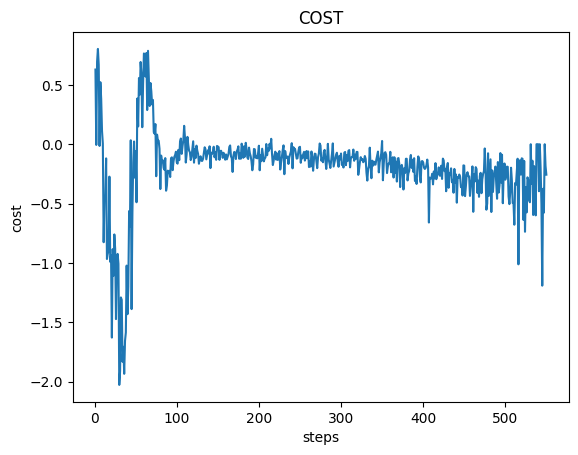

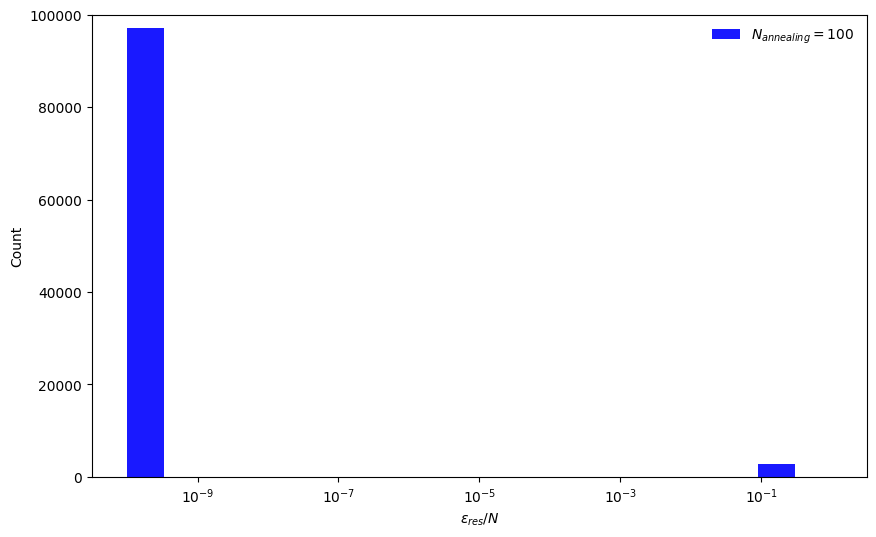

In [8]:
# cost plot
plt.figure()
plt.xlabel("steps")
plt.ylabel("cost")
plt.title("COST")
plt.plot(range(1,num_steps+1), costList)
plt.show()

# epsilon of final test (the end of annealing) 直方图
MIN, MAX = 1e-10, 1.0
groundE = -(N-1)
epsilon = ((energies_final - groundE)/N) # residual energy per site
epsilon[epsilon==0.0] = MIN

plt.figure(figsize=(10,6))
plt.hist(epsilon, alpha=0.9, color='b', bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 20), label='$N_{annealing}='+str(num_annealing_steps)+'$')

plt.gca().set_xscale("log")
plt.ylim(0, len(energies_final))
plt.legend(loc='best', frameon=False)
plt.xlabel(r'$\epsilon_{res}/N$')
plt.ylabel('Count')
plt.show()